In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from math import ceil
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
import itertools as it
import pickle

%matplotlib inline


In [2]:
tab = pd.read_csv("DatasetML.csv")

In [3]:
tab.head()

,C1,N1,C2,C3,N2,C4,C5,N3,C5.1,C6,...,C7,N5,C8,C9,N6,C10,N7,C11,C12,LABEL
0,Z11,6,Z34,Z43,1169,Z65,Z75,4,Z93,Z101,...,Z121,67,Z143,Z152,2,Z173,1,Z192,Z201,1
1,Z12,48,Z32,Z43,5951,Z61,Z73,2,Z92,Z101,...,Z121,22,Z143,Z152,1,Z173,1,Z191,Z201,2
2,Z14,12,Z34,Z46,2096,Z61,Z74,2,Z93,Z101,...,Z121,49,Z143,Z152,1,Z172,2,Z191,Z201,1
3,Z11,42,Z32,Z42,7882,Z61,Z74,2,Z93,Z103,...,Z122,45,Z143,Z153,1,Z173,2,Z191,Z201,1
4,Z11,24,Z33,Z40,4870,Z61,Z73,3,Z93,Z101,...,Z124,53,Z143,Z153,2,Z173,2,Z191,Z201,2


In [4]:
tab.info()
# 1000 rows
# categorical variables seem to start their name by C
# numerical variables seem to start their name by N
# there no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
C1       1000 non-null object
N1       1000 non-null int64
C2       1000 non-null object
C3       1000 non-null object
N2       1000 non-null int64
C4       1000 non-null object
C5       1000 non-null object
N3       1000 non-null int64
C5.1     1000 non-null object
C6       1000 non-null object
N4       1000 non-null int64
C7       1000 non-null object
N5       1000 non-null int64
C8       1000 non-null object
C9       1000 non-null object
N6       1000 non-null int64
C10      1000 non-null object
N7       1000 non-null int64
C11      1000 non-null object
C12      1000 non-null object
LABEL    1000 non-null int64
dtypes: int64(8), object(13)
memory usage: 164.2+ KB


In [5]:
# confirm number of missing values
tab.isna().sum()

C1       0
N1       0
C2       0
C3       0
N2       0
C4       0
C5       0
N3       0
C5.1     0
C6       0
N4       0
C7       0
N5       0
C8       0
C9       0
N6       0
C10      0
N7       0
C11      0
C12      0
LABEL    0
dtype: int64

In [6]:
# number of unique values for each attribute
tab.apply(lambda x: len(x.unique()))
# only N1, N2 and N5 have a wider range of values
# other attributes may represent categories

C1         4
N1        33
C2         5
C3        10
N2       921
C4         5
C5         5
N3         4
C5.1       4
C6         3
N4         4
C7         4
N5        53
C8         3
C9         3
N6         4
C10        4
N7         2
C11        2
C12        2
LABEL      2
dtype: int64

In [7]:
cat_v = tab.columns[tab.dtypes=="object"]
print(tab[cat_v].head())
for a in cat_v:
    print(tab[a].value_counts())

# categorical variables are composed by: Z+(column number)+quantitative value (e.g., Z101 = Z+10+1)


    C1   C2   C3   C4   C5 C5.1    C6    C7    C8    C9   C10   C11   C12
0  Z11  Z34  Z43  Z65  Z75  Z93  Z101  Z121  Z143  Z152  Z173  Z192  Z201
1  Z12  Z32  Z43  Z61  Z73  Z92  Z101  Z121  Z143  Z152  Z173  Z191  Z201
2  Z14  Z34  Z46  Z61  Z74  Z93  Z101  Z121  Z143  Z152  Z172  Z191  Z201
3  Z11  Z32  Z42  Z61  Z74  Z93  Z103  Z122  Z143  Z153  Z173  Z191  Z201
4  Z11  Z33  Z40  Z61  Z73  Z93  Z101  Z124  Z143  Z153  Z173  Z191  Z201
Z14    394
Z11    274
Z12    269
Z13     63
Name: C1, dtype: int64
Z32    530
Z34    293
Z33     88
Z31     49
Z30     40
Name: C2, dtype: int64
Z43     280
Z40     234
Z42     181
Z41     103
Z49      97
Z46      50
Z45      22
Z410     12
Z44      12
Z48       9
Name: C3, dtype: int64
Z61    603
Z65    183
Z62    103
Z63     63
Z64     48
Name: C4, dtype: int64
Z73    339
Z75    253
Z74    174
Z72    172
Z71     62
Name: C5, dtype: int64
Z93    548
Z92    310
Z94     92
Z91     50
Name: C5.1, dtype: int64
Z101    907
Z103     52
Z102     41
Name: C

In [8]:
# Z+column number is present in whole column so we don't lose information by removing it
for i in range(tab.shape[1]):
    tab.iloc[:,i] = tab.iloc[:,i].replace(to_replace="^Z"+str(i+1),value="",regex=True)

tab = tab.astype("int64")
print(tab.info())
print(tab.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
C1       1000 non-null int64
N1       1000 non-null int64
C2       1000 non-null int64
C3       1000 non-null int64
N2       1000 non-null int64
C4       1000 non-null int64
C5       1000 non-null int64
N3       1000 non-null int64
C5.1     1000 non-null int64
C6       1000 non-null int64
N4       1000 non-null int64
C7       1000 non-null int64
N5       1000 non-null int64
C8       1000 non-null int64
C9       1000 non-null int64
N6       1000 non-null int64
C10      1000 non-null int64
N7       1000 non-null int64
C11      1000 non-null int64
C12      1000 non-null int64
LABEL    1000 non-null int64
dtypes: int64(21)
memory usage: 164.2 KB
None
   C1  N1  C2  C3    N2  C4  C5  N3  C5.1  C6  ...  C7  N5  C8  C9  N6  C10  \
0   1   6   4   3  1169   5   5   4     3   1  ...   1  67   3   2   2    3   
1   2  48   2   3  5951   1   3   2     2   1  ...   1  22   3   2   1    3   
2 

In [9]:
# statistics of numerical features
tab.describe()

,C1,N1,C2,C3,N2,C4,C5,N3,C5.1,C6,...,C7,N5,C8,C9,N6,C10,N7,C11,C12,LABEL
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.577000,20.903000,2.54500,2.828000,3271.258000,2.105000,3.384000,2.973000,2.68200,1.145000,...,2.358000,35.546000,2.675000,1.929000,1.407000,2.904000,1.155000,1.404000,1.037000,1.300000
std,1.257638,12.058814,1.08312,2.744439,2822.736876,1.580023,1.208306,1.118715,0.70808,0.477706,...,1.050209,11.375469,0.705601,0.531264,0.577654,0.653614,0.362086,0.490943,0.188856,0.458487
min,1.000000,4.000000,0.00000,0.000000,250.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,12.000000,2.00000,1.000000,1365.500000,1.000000,3.000000,2.000000,2.00000,1.000000,...,1.000000,27.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,18.000000,2.00000,2.000000,2319.500000,1.000000,3.000000,3.000000,3.00000,1.000000,...,2.000000,33.000000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000
75%,4.000000,24.000000,4.00000,3.000000,3972.250000,3.000000,5.000000,4.000000,3.00000,1.000000,...,3.000000,42.000000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000,2.000000
max,4.000000,72.000000,4.00000,10.000000,18424.000000,5.000000,5.000000,4.000000,4.00000,3.000000,...,4.000000,75.000000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000,2.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10efcbc18>,
      dtype=object)

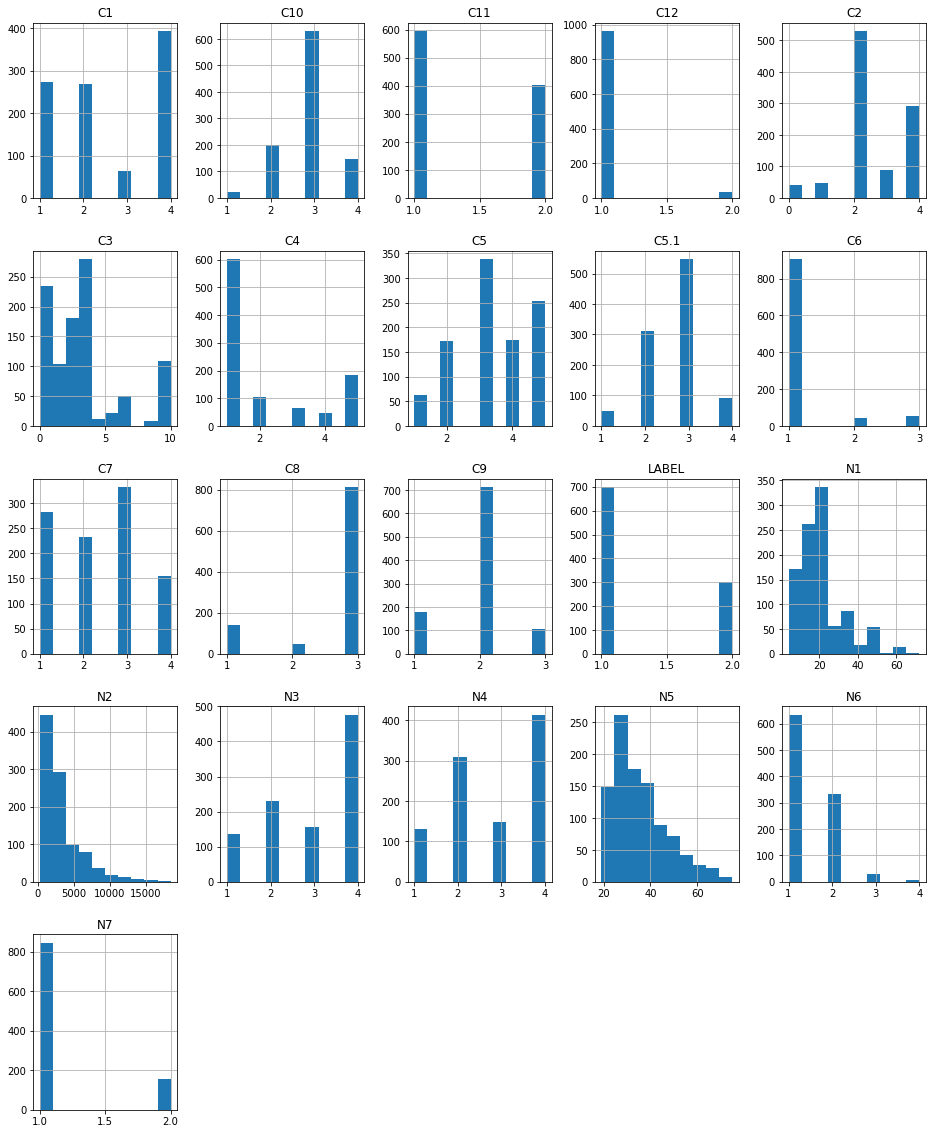

In [10]:
# histograms
tab.hist(figsize=(16, 20))

In [11]:
tab.LABEL.value_counts()
# output distribution is slightly unbalanced


1    700
2    300
Name: LABEL, dtype: int64

In [12]:
# subtract by 1 to have 1 for positive cases and 0 for negative cases
tab.LABEL = tab.LABEL - 1

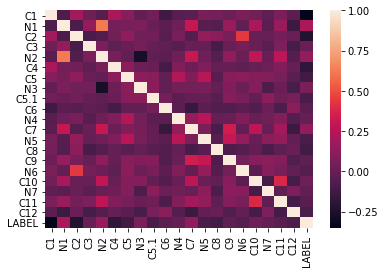

In [13]:
sns.heatmap(tab.corr())
# there are no variables that are so correlated that we can exclude

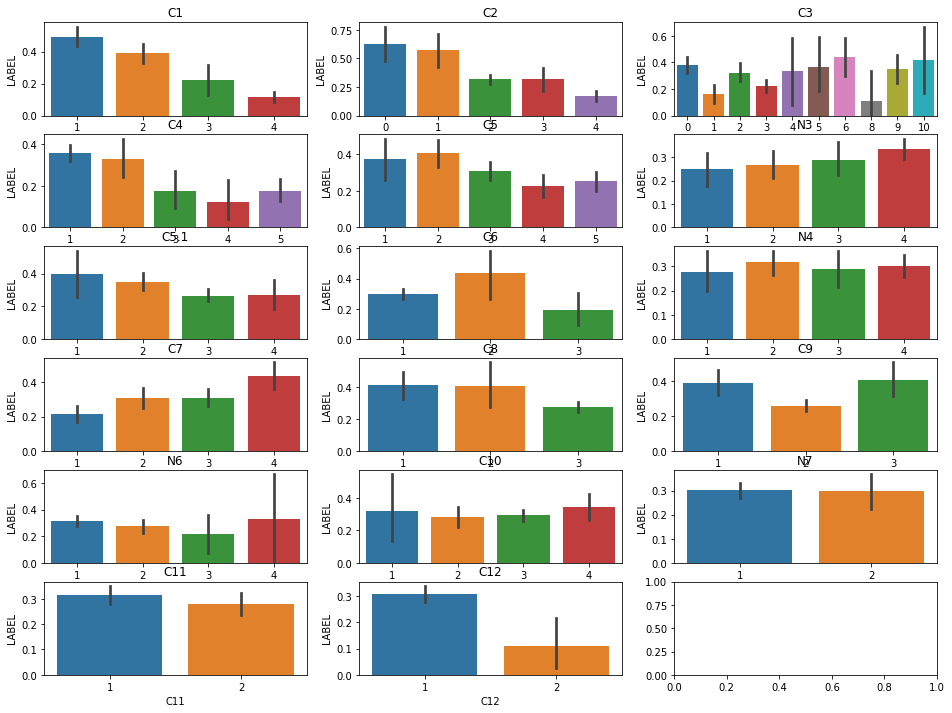

In [14]:
# output distribution for each attribute value except for clearly continuous attributes (N!,N2,N5)
aux = tab.columns[np.isin(tab.columns,['N1','N2','N5','LABEL'])==False]
fig, saxis = plt.subplots(ceil(len(aux)/3), 3,figsize=(16,12))
v_count = 0
for a in aux:
    fig = sns.barplot(x=a,y='LABEL',data=tab, ax = saxis[(v_count//3),(v_count%3)])
    saxis[(v_count//3),(v_count%3)].set_title(a)
    v_count = v_count + 1

# some have gradual association with output, or almost non-existent association
# however, other attributes have irregular association. For instance, in C3 6 have high % while 8 has low and 9 has high also
# for these situations it may beneficial to use one hot encoding for some methods (e.g., neural networks, logistic regression)
class_ohe = ["C3","C4","C6","C9","C10","N6"]
# I choose xgboost to model this use case. One hot encoding is not important for this method so I didn't apply it.


In [15]:
# separate input variables and output
tabX = tab.drop(columns="LABEL").copy()
tabY = tab.LABEL.copy()


In [16]:
# create evaluation scheme
# 25% for testing, 5 fold cross~validation to select hyperparameters

num_row = tab.shape[0]
nseed = 321 # for reproducibility
n_folds = 5 # set folds for out-of-fold prediction
k_fold = StratifiedKFold(n_splits= n_folds, shuffle=True, random_state=nseed)

X_train, X_test, y_train, y_test = train_test_split(tabX, tabY, stratify=tabY, test_size=0.25, random_state=nseed)

In [17]:
# since this is a binary classification problem, I choose the binary:logistic objective function.
# I preferred "auc"(ROC AUC) relatively to "error" as evaluation metric because it is a measure that do not assume 
# an unique decision value like "error"
params_xgb = {'eta':0.05,
'min_child_weight':3,
'max_depth':3,
'subsample':1.0,
'colsample_bytree':0.7,
'objective':'binary:logistic',
'eval_metric':'auc'} 


In [18]:
# sets of hyperparameters to evaluate and select using grid search
param_xgboost = {
 'max_depth':[3,4,5],
 'min_child_weight':[3,4,5],
'eta':[0.01,0.05,0.1],
    'subsample':[0.6,0.8,1],
    'colsample_bytree':[0.6,0.8,1]
}


In [19]:
# create train and test datasets for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [20]:
# select the best hyperparameters for xgboost in training dataset
def grid_search_xgb(grid_params,df_train,kf):
    allNames = sorted(grid_params)
    combinations = it.product(*(grid_params[Name] for Name in allNames))
    comb_params = [dict(zip(allNames,a)) for a in combinations]
    best_score = 0
    best_params = comb_params[0]
    for p in comb_params:
        p.update( {'objective':'binary:logistic','eval_metric':'auc'})
        cv_res = xgb.cv(p,df_train,folds=kf,num_boost_round=1000,early_stopping_rounds=50,verbose_eval=False)
        c_score = cv_res[['test-auc-mean']].max().values[0]
        if best_score<c_score:
            best_score=c_score
            best_params = p
    return best_params, best_score

In [21]:
best_params, best_score = grid_search_xgb(param_xgboost,dtrain,k_fold)
print(best_score)
print(best_params)

0.8036823999999999
{'colsample_bytree': 1, 'eta': 0.05, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6, 'objective': 'binary:logistic', 'eval_metric': 'auc'}


In [22]:
def create_model(prms, df_train,kf):
    cv_res = xgb.cv(prms,df_train,folds=kf,num_boost_round=10000,early_stopping_rounds=50,verbose_eval=False)
    xgb_model = xgb.train(prms, df_train, num_boost_round=cv_res.shape[0])
    return xgb_model


In [23]:
xgb_model = create_model(best_params,dtrain,k_fold)

In [24]:
y_pred = xgb_model.predict(dtest)


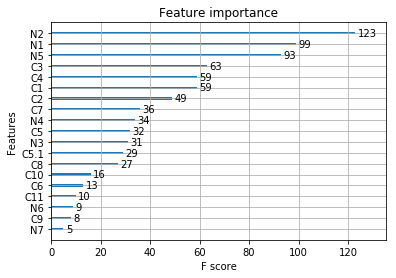

In [25]:
# feature importance
xgb.plot_importance(xgb_model)

In [26]:
# evaluation: 
# - plot for ROC and Precision Recall Curve
# - AUC ROC
# - maximum F1 score and assuming this value:
# -      threshold
# -      precision
# -      recall
# -      accuracy
def evaluation(yTest,yPred):
    fpr, tpr, thresholds = metrics.roc_curve(yTest,yPred)
    plt.plot(fpr, tpr, marker='.', label='Classification')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend()
    plt.show()
    precision, recall, thresholds = metrics.precision_recall_curve(yTest,yPred)
    plt.plot(recall, precision, marker='.', label='Classification')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show()
    print('AUC ROC: ',metrics.roc_auc_score(yTest,yPred))
    f1_score = 2*recall*precision/(recall+precision)
    v_ind = np.argmax(f1_score)
    print('Max F1-Score: ', f1_score[v_ind])
    print('Threshold: ', thresholds[v_ind])
    print('Precision: ', precision[v_ind])
    print('Recall: ', recall[v_ind])
    thrs = thresholds[v_ind]
    pred_label = yPred.copy()
    pred_label[yPred<thrs] = 0
    pred_label[yPred>=thrs] = 1
    print('Accuracy: ',metrics.accuracy_score(yTest,pred_label))

    

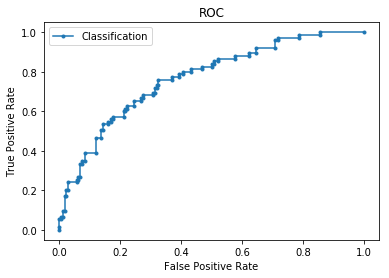

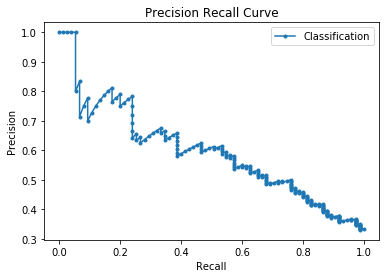

AUC ROC:  0.7683047619047618
Max F1-Score:  0.6031746031746031
Threshold:  0.22746389
Precision:  0.5
Recall:  0.76
Accuracy:  0.7


In [27]:
evaluation(y_test,y_pred)

In [28]:
# Test set: AUC 0.768, maximum F1 score is 0.6. For this F1 score, we obtain 50% precision and 76% recall 
# for the positive class and the overall accuracy is 70%.

In [29]:
# save model
# xgb_model.save_model("challenge.model")
pickle.dump(xgb_model, open("challenge.pkl", "wb"))